# Import the Packages

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer, PowerTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from feature_engine.encoding import RareLabelEncoder, MeanEncoder, CountFrequencyEncoder
from feature_engine.datetime import DatetimeFeatures
from feature_engine.outliers import Winsorizer
import seaborn as sns

#from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin
from sklearn.metrics.pairwise import rbf_kernel
from preprocess_functions import is_north_city, is_direct_flight, duration_categories, have_info, part_of_day, RbfSimilarityScore
import joblib
#import pickle as pkl

# Load the Data

In [2]:
pwd

'd:\\Flight-Price-Prediction\\new_notebooks'

In [3]:
# load the train data

train_data_path = Path('new_data/train.csv')

train_df = pd.read_csv(train_data_path)

train_df.head()

,airline,date_of_journey,source,destination,departure_time,arrival_time,duration,total_stops,additional_info,price
0,Indigo,2019-06-15,Delhi,Cochin,05:35:00,08:50:00,195,0,No Info,5601
1,Jet_Airways,2019-05-09,Delhi,Cochin,10:00:00,19:00:00,540,1,No Info,15554
2,Spicejet,2019-05-18,Mumbai,Hyderabad,13:15:00,14:45:00,90,0,No Info,2227
3,Indigo,2019-05-06,Kolkata,Banglore,08:10:00,13:00:00,290,1,No Info,5069
4,Air_India,2019-03-21,Delhi,Cochin,23:00:00,19:15:00,1215,1,No Info,6745


In [4]:
# load the test data

test_data_path = Path('new_data/test.csv')

test_df = pd.read_csv(test_data_path)

test_df.head()

,airline,date_of_journey,source,destination,departure_time,arrival_time,duration,total_stops,additional_info,price
0,Jet_Airways,2019-03-06,Banglore,Delhi,08:00:00,08:15:00,1455,1,No Info,17996
1,Spicejet,2019-06-06,Kolkata,Banglore,22:20:00,00:40:00,140,0,No Info,3873
2,Indigo,2019-03-18,Kolkata,Banglore,05:30:00,08:20:00,170,0,No Info,4462
3,Indigo,2019-06-27,Chennai,Kolkata,19:35:00,21:55:00,140,0,No Info,3597
4,Indigo,2019-05-06,Kolkata,Banglore,15:15:00,17:45:00,150,0,No Info,4804


## Check for missing values

In [5]:
# check in training data

train_df.isna().sum()

airline            0
date_of_journey    0
source             0
destination        0
departure_time     0
arrival_time       0
duration           0
total_stops        0
additional_info    0
price              0
dtype: int64

In [6]:
# check in test data

test_df.isna().sum()

airline            0
date_of_journey    0
source             0
destination        0
departure_time     0
arrival_time       0
duration           0
total_stops        0
additional_info    0
price              0
dtype: int64

## Check for duplicate rows

In [7]:
# check in training data

train_df.duplicated().sum()

0

In [8]:
# check in test data

test_df.duplicated().sum()

0

**There are no rows in both training and test data that contains either any missing values or any duplicate rows**

## Data types

In [9]:
list_dtypes_train = train_df.dtypes.to_list()

list_dtypes_test = test_df.dtypes.to_list()

print('Are the data types same in both train and test data -->',list_dtypes_train == list_dtypes_test)

Are the data types same in both train and test data --> True


**Data types of all columns are same in both the train and test data**

# Column Wise Transformations

In [10]:
import sklearn

sklearn.set_config(display='diagram',
                  transform_output='pandas')

## Airline

In [11]:
(
    train_df
    .loc[:,'airline']
    .value_counts(normalize=True)
    .loc[lambda x: (x > 0.1)]
    #.unique()
    .count()
)

4

In [12]:
airline_pipe = Pipeline(steps=[
    ('group_rare',RareLabelEncoder(tol=0.1,n_categories=3,replace_with='Other')),
    ('onehot',OneHotEncoder(sparse_output=False,handle_unknown='ignore'))
])

airline_pipe.fit_transform(train_df.loc[:,['airline']])

,airline_Air_India,airline_Indigo,airline_Jet_Airways,airline_Multiple_Carriers,airline_Other
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
8364,0.0,1.0,0.0,0.0,0.0
8365,0.0,0.0,1.0,0.0,0.0
8366,0.0,1.0,0.0,0.0,0.0
8367,0.0,1.0,0.0,0.0,0.0


In [13]:
airline_pipe

Pipeline(steps=[('group_rare',
                 RareLabelEncoder(n_categories=3, replace_with='Other',
                                  tol=0.1)),
                ('onehot',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

## Date of journey

In [14]:
train_df.head()

,airline,date_of_journey,source,destination,departure_time,arrival_time,duration,total_stops,additional_info,price
0,Indigo,2019-06-15,Delhi,Cochin,05:35:00,08:50:00,195,0,No Info,5601
1,Jet_Airways,2019-05-09,Delhi,Cochin,10:00:00,19:00:00,540,1,No Info,15554
2,Spicejet,2019-05-18,Mumbai,Hyderabad,13:15:00,14:45:00,90,0,No Info,2227
3,Indigo,2019-05-06,Kolkata,Banglore,08:10:00,13:00:00,290,1,No Info,5069
4,Air_India,2019-03-21,Delhi,Cochin,23:00:00,19:15:00,1215,1,No Info,6745


In [15]:
(
    pd.to_datetime(
        train_df
        .date_of_journey)
    .dt.month
    .unique()
    
)

array([6, 5, 3, 4])

In [16]:
(
    train_df
    .date_of_journey
    .index
)

RangeIndex(start=0, stop=8369, step=1)

In [17]:
# make the list of features to extract

features_to_extract = ["month",
                      "week",
                      "day_of_week",
                      "day_of_month",
                       "weekend"]

In [18]:
date_of_journey_pipe = Pipeline(steps=[
    ('datetime',DatetimeFeatures(features_to_extract=features_to_extract,dayfirst=False)),
    ('scaling',MinMaxScaler())
])

date_of_journey_pipe.fit_transform(train_df.loc[:,['date_of_journey']])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_month,date_of_journey_weekend
0,1.000000,0.882353,0.833333,0.538462,1.0
1,0.666667,0.588235,0.500000,0.307692,0.0
2,0.666667,0.647059,0.833333,0.653846,1.0
3,0.666667,0.588235,0.000000,0.192308,0.0
4,0.000000,0.176471,0.500000,0.769231,0.0
...,...,...,...,...,...
8364,1.000000,0.823529,0.000000,0.076923,0.0
8365,0.000000,0.176471,0.500000,0.769231,0.0
8366,0.333333,0.294118,0.333333,0.076923,0.0
8367,0.333333,0.470588,0.833333,1.000000,1.0


## Source/Destination

In [19]:
(
    train_df
    .source
    .value_counts(normalize=True)
)

source
Delhi       0.412475
Kolkata     0.273031
Banglore    0.211136
Mumbai      0.067631
Chennai     0.035727
Name: proportion, dtype: float64

In [20]:
(
    train_df
    .destination
    .value_counts(normalize=True)
)

destination
Cochin       0.412475
Banglore     0.273031
Delhi        0.211136
Hyderabad    0.067631
Kolkata      0.035727
Name: proportion, dtype: float64

In [21]:
location_subset = train_df.loc[:,['source','destination']]

location_subset

,source,destination
0,Delhi,Cochin
1,Delhi,Cochin
2,Mumbai,Hyderabad
3,Kolkata,Banglore
4,Delhi,Cochin
...,...,...
8364,Banglore,Delhi
8365,Banglore,Delhi
8366,Delhi,Cochin
8367,Delhi,Cochin


In [22]:
# pipeline 1 for source and destination

location_pipe_1 = Pipeline(steps=[
    ('group_cat',RareLabelEncoder(tol=0.2,n_categories=3,replace_with='Other')),
    ('encoding',MeanEncoder(smoothing=0.1)),
    ('power',PowerTransformer())
])

location_pipe_1.fit_transform(location_subset,train_df.loc[:,'price'])

,source,destination
0,1.047751,1.047751
1,1.047751,1.047751
2,-1.878825,-1.878825
3,-0.168404,-0.168404
4,1.047751,1.047751
...,...,...
8364,-0.909366,-0.909366
8365,-0.909366,-0.909366
8366,1.047751,1.047751
8367,1.047751,1.047751


In [23]:
unique_cities_source = (
                            train_df
                            .source
                            .unique()
                        )

unique_cities_source

array(['Delhi', 'Mumbai', 'Kolkata', 'Banglore', 'Chennai'], dtype=object)

In [24]:
unique_cities_destination = (
                            train_df
                            .destination
                            .unique()
                        )

unique_cities_destination

array(['Cochin', 'Hyderabad', 'Banglore', 'Delhi', 'Kolkata'],
      dtype=object)

In [25]:
np.union1d(unique_cities_source,unique_cities_destination)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai'], dtype=object)

In [26]:
# def is_north_city(df):
#     df_columns = df.columns.to_list()
#     north_cities = ['Delhi','Kolkata']

#     return (
#         df.assign(**{
#             f"{col}_is_north" : (df
#                                  .loc[:,col]
#                                 .isin(north_cities)
#                                 .astype(int))
#             for col in df_columns
#         })
#         .drop(columns=df_columns)
#     )

In [27]:
is_north_city(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,0,0
3,1,0
4,1,0
...,...,...
8364,0,1
8365,0,1
8366,1,0
8367,1,0


In [28]:
# pipeline 2 for source and destination


location_pipe_2 = FunctionTransformer(func=is_north_city)

location_pipe_2.fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,0,0
3,1,0
4,1,0
...,...,...
8364,0,1
8365,0,1
8366,1,0
8367,1,0


In [29]:
location_pipe_2

FunctionTransformer(func=<function is_north_city at 0x00000268A00F0E00>)

In [30]:
location_transformer = FeatureUnion(transformer_list=[
    ('step1',location_pipe_1),
    ('step2',location_pipe_2)
],n_jobs=-1)

location_transformer.fit_transform(location_subset,train_df.loc[:,'duration'])

,source,destination,source_is_north,destination_is_north
0,0.797395,0.797395,1,0
1,0.797395,0.797395,1,0
2,-1.708751,-1.708751,0,0
3,0.472713,0.472713,1,0
4,0.797395,0.797395,1,0
...,...,...,...,...
8364,-1.332590,-1.332590,0,1
8365,-1.332590,-1.332590,0,1
8366,0.797395,0.797395,1,0
8367,0.797395,0.797395,1,0


## Arrival/Departure time

In [31]:
(
    train_df
    .loc[:,['arrival_time','departure_time']]
    .dtypes
)

arrival_time      object
departure_time    object
dtype: object

In [32]:
time_subset = train_df.loc[:,['arrival_time','departure_time']]

time_subset

,arrival_time,departure_time
0,08:50:00,05:35:00
1,19:00:00,10:00:00
2,14:45:00,13:15:00
3,13:00:00,08:10:00
4,19:15:00,23:00:00
...,...,...
8364,11:20:00,08:30:00
8365,21:20:00,07:00:00
8366,15:35:00,10:35:00
8367,08:50:00,05:35:00


In [33]:
time_pipe_1 = Pipeline(steps=[
    ('datetime',DatetimeFeatures(features_to_extract=['hour','minute'],format='mixed')),
    ('scaling',MinMaxScaler())
])

time_pipe_1.fit_transform(time_subset)

,arrival_time_hour,arrival_time_minute,departure_time_hour,departure_time_minute
0,0.347826,0.909091,0.217391,0.636364
1,0.826087,0.000000,0.434783,0.000000
2,0.608696,0.818182,0.565217,0.272727
3,0.565217,0.000000,0.347826,0.181818
4,0.826087,0.272727,1.000000,0.000000
...,...,...,...,...
8364,0.478261,0.363636,0.347826,0.545455
8365,0.913043,0.363636,0.304348,0.000000
8366,0.652174,0.636364,0.434783,0.636364
8367,0.347826,0.909091,0.217391,0.636364


In [34]:
# def part_of_day(df,morning=6,noon=12,evening=16,night=21):
#     columns = df.columns.to_list()

#     time_df = df.assign(**{
#         col: pd.to_datetime(df.loc[:,col],format='mixed').dt.hour
#         for col in columns
#     })

#     return (
#         time_df.assign(**{
#             f'{col}_part_of_day' : (
#                 np.select(condlist=[time_df.loc[:,col].between(morning,noon,inclusive='left'),
#                                     time_df.loc[:,col].between(noon,evening,inclusive='left'),
#                                     time_df.loc[:,col].between(evening,night,inclusive='left')],
#                          choicelist=["morning",
#                                      "noon",
#                                      "evening"],
#                          default="night")
#             )
#             for col in columns
#         })
#         .drop(columns=columns)
#     )

In [35]:
time_pipe_2 = Pipeline(steps=[
    ('part_of_day',FunctionTransformer(func=part_of_day)),
    ('count_encode',CountFrequencyEncoder(encoding_method='count')),
    ('scaling',MinMaxScaler())
])

time_pipe_2.fit_transform(time_subset)

,arrival_time_part_of_day,departure_time_part_of_day
0,0.303222,0.221636
1,0.673405,1.000000
2,0.000000,0.000000
3,0.000000,1.000000
4,0.673405,0.221636
...,...,...
8364,0.303222,1.000000
8365,1.000000,1.000000
8366,0.000000,1.000000
8367,0.303222,0.221636


In [36]:
time_transformer = FeatureUnion(transformer_list=[
    ("step_1",time_pipe_1),
    ("step_2",time_pipe_2)
],n_jobs=-1)

time_transformer.fit_transform(time_subset)

,arrival_time_hour,arrival_time_minute,departure_time_hour,departure_time_minute,arrival_time_part_of_day,departure_time_part_of_day
0,0.347826,0.909091,0.217391,0.636364,0.303222,0.221636
1,0.826087,0.000000,0.434783,0.000000,0.673405,1.000000
2,0.608696,0.818182,0.565217,0.272727,0.000000,0.000000
3,0.565217,0.000000,0.347826,0.181818,0.000000,1.000000
4,0.826087,0.272727,1.000000,0.000000,0.673405,0.221636
...,...,...,...,...,...,...
8364,0.478261,0.363636,0.347826,0.545455,0.303222,1.000000
8365,0.913043,0.363636,0.304348,0.000000,1.000000,1.000000
8366,0.652174,0.636364,0.434783,0.636364,0.000000,1.000000
8367,0.347826,0.909091,0.217391,0.636364,0.303222,0.221636


## Duration

<Axes: xlabel='duration', ylabel='Density'>

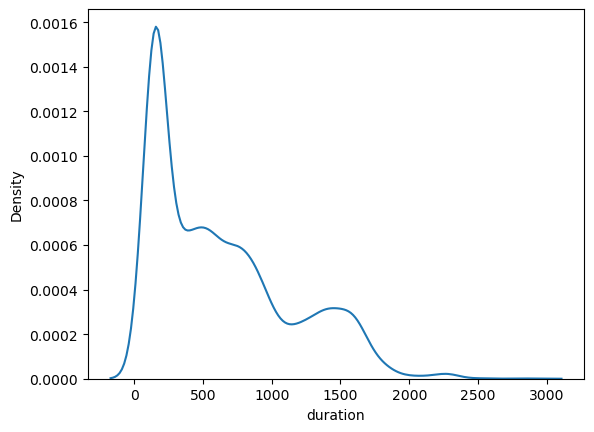

In [37]:
sns.kdeplot(train_df.loc[:,'duration'])

<Axes: ylabel='price'>

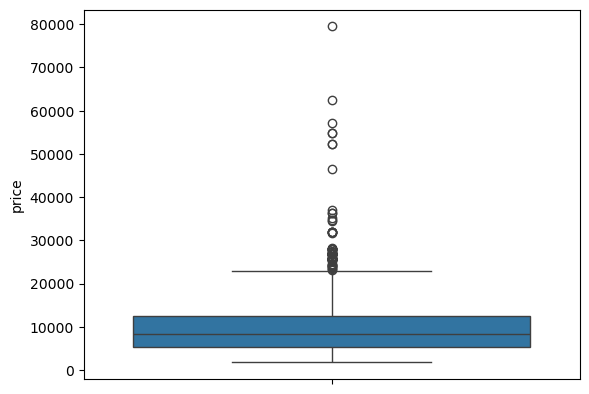

In [38]:
sns.boxplot(data=train_df,y='price')

In [39]:
(
    train_df
    .duration
    .agg(['min','max'])
)

min      75
max    2860
Name: duration, dtype: int64

In [40]:
# def duration_categories(df,short=0,medium=400,long=1000):
#     return (
#         df.assign(
#             duration_category = np.select(
#                 condlist=[df.loc[:,'duration'].between(short,medium,inclusive='left'),
#                          (df.loc[:,'duration'].between(medium,long,inclusive='left'))],
#                 choicelist=['short','medium'],
#                 default='long'
#             )
#         )
#         .drop(columns='duration')
#     )

In [41]:
duration_categories(train_df.loc[:,['duration']])

,duration_category
0,short
1,medium
2,short
3,short
4,long
...,...
8364,short
8365,medium
8366,short
8367,short


In [42]:
category_pipe = Pipeline(steps=[
    ('duration_cat',FunctionTransformer(duration_categories)),
    ('ord_encode',OrdinalEncoder(categories=[['short','medium','long']]))
])

category_pipe.fit_transform(train_df.loc[:,['duration']])

,duration_category
0,0.0
1,1.0
2,0.0
3,0.0
4,2.0
...,...
8364,0.0
8365,1.0
8366,0.0
8367,0.0


In [43]:
(
    train_df
    .loc[:,['duration']]
    .quantile([0.25,0.5,0.75])
    .values
)

array([[170.],
       [505.],
       [920.]])

In [44]:
# build the class for rbf kernel

# class RbfSimilarityScore(TransformerMixin, BaseEstimator, OneToOneFeatureMixin):

#     def __init__(self,percentiles,variables=None):
#         self.percentiles = percentiles
#         self.variables = variables

#     def fit(self,X,y=None):
#         if not self.variables:
#             self.variables = X.columns.to_list()
#         self.reference_values_ = (
#             {col: X.loc[:,[col]].quantile(self.percentiles).values
#             for col in self.variables}
#         )
#         return self

#     def transform(self,X):
#         return ( X.assign(**{
#                 f'{int(percentile * 100)}percentile_rbf_score' : rbf_kernel(X=X.loc[:,self.variables],
#                                                                             Y=self.reference_values_[self.variables[0]][ind,:].reshape(-1,1))
#                 for ind,percentile in enumerate(self.percentiles)})
#                 .drop(columns=self.variables)
#                )

In [45]:
rbf = RbfSimilarityScore([0.25,0.5,0.75],['duration'])

rbf.fit(train_df)

rbf.transform(train_df.loc[:,['duration']])

,25percentile_rbf_score,50percentile_rbf_score,75percentile_rbf_score
0,3.680856e-272,0.0,0.0
1,0.000000e+00,0.0,0.0
2,0.000000e+00,0.0,0.0
3,0.000000e+00,0.0,0.0
4,0.000000e+00,0.0,0.0
...,...,...,...
8364,1.000000e+00,0.0,0.0
8365,0.000000e+00,0.0,0.0
8366,0.000000e+00,0.0,0.0
8367,3.680856e-272,0.0,0.0


In [46]:
rbf_pipe = Pipeline(steps=[
    ('rbf_similiraity',RbfSimilarityScore([0.25,0.5,0.75])),
    ('transform',PowerTransformer())
])

rbf_pipe.fit_transform(train_df.loc[:,['duration']])

,25percentile_rbf_score,50percentile_rbf_score,75percentile_rbf_score
0,-0.235568,-0.071865,-0.055825
1,-0.235568,-0.071865,-0.055825
2,-0.235568,-0.071865,-0.055825
3,-0.235568,-0.071865,-0.055825
4,-0.235568,-0.071865,-0.055825
...,...,...,...
8364,4.245051,-0.071865,-0.055825
8365,-0.235568,-0.071865,-0.055825
8366,-0.235568,-0.071865,-0.055825
8367,-0.235568,-0.071865,-0.055825


In [47]:
duration_union = FeatureUnion(transformer_list=[
    ('category',category_pipe),
    ('rbf',rbf_pipe)
])

duration_union.fit_transform(train_df.loc[:,['duration']])

,duration_category,25percentile_rbf_score,50percentile_rbf_score,75percentile_rbf_score
0,0.0,-0.235568,-0.071865,-0.055825
1,1.0,-0.235568,-0.071865,-0.055825
2,0.0,-0.235568,-0.071865,-0.055825
3,0.0,-0.235568,-0.071865,-0.055825
4,2.0,-0.235568,-0.071865,-0.055825
...,...,...,...,...
8364,0.0,4.245051,-0.071865,-0.055825
8365,1.0,-0.235568,-0.071865,-0.055825
8366,0.0,-0.235568,-0.071865,-0.055825
8367,0.0,-0.235568,-0.071865,-0.055825


In [48]:
duration_transformer = Pipeline(steps=[
    ('outliers',Winsorizer(capping_method='iqr',fold=1.5,tail='both')),
    ('transformer',duration_union)
])


duration_transformer.fit_transform(train_df.loc[:,['duration']])

,duration_category,25percentile_rbf_score,50percentile_rbf_score,75percentile_rbf_score
0,0.0,-0.235568,-0.071865,-0.055825
1,1.0,-0.235568,-0.071865,-0.055825
2,0.0,-0.235568,-0.071865,-0.055825
3,0.0,-0.235568,-0.071865,-0.055825
4,2.0,-0.235568,-0.071865,-0.055825
...,...,...,...,...
8364,0.0,4.245051,-0.071865,-0.055825
8365,1.0,-0.235568,-0.071865,-0.055825
8366,0.0,-0.235568,-0.071865,-0.055825
8367,0.0,-0.235568,-0.071865,-0.055825


## Total Stops

In [49]:
(
    train_df
    .total_stops
)

0       0
1       1
2       0
3       1
4       1
       ..
8364    0
8365    1
8366    1
8367    0
8368    2
Name: total_stops, Length: 8369, dtype: int64

In [50]:
# def is_direct_flight(df):
#     columns = df.columns.to_list()

#     return(
#         df.assign(**{
#             f"is_drect": np.where(df.loc[:,col] == 0, 1, 0)
#             for col in columns
#         })
#     )

## Additional Info

In [51]:
(
    train_df
    .additional_info
    .value_counts(normalize=True)
)

additional_info
No Info                         0.784323
In-flight meal not included     0.182579
No check-in baggage included    0.029753
1 Long layover                  0.001912
Change airports                 0.000597
Business class                  0.000478
2 Long layover                  0.000119
Red-eye flight                  0.000119
1 Short layover                 0.000119
Name: proportion, dtype: float64

In [52]:
info_pipe_1 = Pipeline(steps=[
    ('rare_labels',RareLabelEncoder(tol=0.1,n_categories=2,replace_with='Others')),
    ('encode',OneHotEncoder(sparse_output=False,handle_unknown='ignore'))
])

info_pipe_1.fit_transform(train_df.loc[:,['additional_info']])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Others
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
8364,0.0,1.0,0.0
8365,1.0,0.0,0.0
8366,0.0,1.0,0.0
8367,0.0,1.0,0.0


In [53]:
# def have_info(df):
#     columns = df.columns.to_list()

#     return(
#         df.assign(**{
#             f"have_info": np.where(df.loc[:,col] == "No Info", 0, 1)
#             for col in columns
#         })
#         .drop(columns=columns)
#     )

In [54]:
info_transformer = FeatureUnion(transformer_list=[
    ('step_1',info_pipe_1),
    ('step_2',FunctionTransformer(func=have_info))
],n_jobs=-1)

info_transformer.fit_transform(train_df.loc[:,['additional_info']])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Others,have_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
8364,0.0,1.0,0.0,0
8365,1.0,0.0,0.0,1
8366,0.0,1.0,0.0,0
8367,0.0,1.0,0.0,0


# Split the data into X and y

In [55]:
X_train = train_df.drop(columns='price')

y_train = train_df.loc[:,'price']

In [56]:
X_train.shape

(8369, 9)

In [57]:
y_train.shape

(8369,)

# Single Transformer for Data

In [58]:
# column transformer for the dataset

preprocessor = ColumnTransformer(transformers=[
    ('airline',airline_pipe,['airline']),
    ('date_of_journey',date_of_journey_pipe,['date_of_journey']),
    ('location',location_transformer,['source','destination']),
    ('time',time_transformer,['arrival_time','departure_time']),
    ('duration',duration_union,['duration']),
    ('stops',FunctionTransformer(func=is_direct_flight),['total_stops']),
    ('additional_info',info_transformer,['additional_info'])
    
],n_jobs=-1,remainder='passthrough')

preprocessor

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('airline',
                                 Pipeline(steps=[('group_rare',
                                                  RareLabelEncoder(n_categories=3,
                                                                   replace_with='Other',
                                                                   tol=0.1)),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['airline']),
                                ('date_of_journey',
                                 Pipeline(steps=[('datetime',
                                                  DatetimeFeatures(features_to_extract=['month',
                                                                                        'w...
                                 ['total_stops']),
                                ('additional_info',
                                 FeatureUnion(n_jobs=-1,
                                              transformer_list=[('step_1',
                                                                 Pipeline(steps=[('rare_labels',
                                                                                  RareLabelEncoder(n_categories=2,
                                                                                                   replace_with='Others',
                                                                                                   tol=0.1)),
                                                                                 ('encode',
                                                                                  OneHotEncoder(handle_unknown='ignore',
                                                                                                sparse_output=False))])),
                                                                ('step_2',
                                                                 FunctionTransformer(func=<function have_info at 0x00000268A00F1080>))]),
                                 ['additional_info'])])

In [59]:
# fit and transform the training data

preprocessor.fit(X_train,y_train)

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('airline',
                                 Pipeline(steps=[('group_rare',
                                                  RareLabelEncoder(n_categories=3,
                                                                   replace_with='Other',
                                                                   tol=0.1)),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['airline']),
                                ('date_of_journey',
                                 Pipeline(steps=[('datetime',
                                                  DatetimeFeatures(features_to_extract=['month',
                                                                                        'w...
                                 ['total_stops']),
                                ('additional_info',
                                 FeatureUnion(n_jobs=-1,
                                              transformer_list=[('step_1',
                                                                 Pipeline(steps=[('rare_labels',
                                                                                  RareLabelEncoder(n_categories=2,
                                                                                                   replace_with='Others',
                                                                                                   tol=0.1)),
                                                                                 ('encode',
                                                                                  OneHotEncoder(handle_unknown='ignore',
                                                                                                sparse_output=False))])),
                                                                ('step_2',
                                                                 FunctionTransformer(func=<function have_info at 0x00000268A00F1080>))]),
                                 ['additional_info'])])

In [60]:
# save the transformer
if __name__ == "__main__":
    save_path = Path('./artifacts/')
    
    save_path.mkdir(exist_ok=True)
    
    joblib.dump(value=preprocessor,filename=save_path / 'preprocessor.joblib')

In [62]:
# load the transformer

preprocessor_loaded = joblib.load(save_path / 'preprocessor.joblib')
preprocessor_loaded

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('airline',
                                 Pipeline(steps=[('group_rare',
                                                  RareLabelEncoder(n_categories=3,
                                                                   replace_with='Other',
                                                                   tol=0.1)),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['airline']),
                                ('date_of_journey',
                                 Pipeline(steps=[('datetime',
                                                  DatetimeFeatures(features_to_extract=['month',
                                                                                        'w...
                                 ['total_stops']),
                                ('additional_info',
                                 FeatureUnion(n_jobs=-1,
                                              transformer_list=[('step_1',
                                                                 Pipeline(steps=[('rare_labels',
                                                                                  RareLabelEncoder(n_categories=2,
                                                                                                   replace_with='Others',
                                                                                                   tol=0.1)),
                                                                                 ('encode',
                                                                                  OneHotEncoder(handle_unknown='ignore',
                                                                                                sparse_output=False))])),
                                                                ('step_2',
                                                                 FunctionTransformer(func=<function have_info at 0x00000268A00F1080>))]),
                                 ['additional_info'])])